Letting Torch to use the GPU

In [ ]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Installing the Transformers library

In [ ]:
!pip install transformers

Importing necessary modules

In [ ]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import transformers

Loading both the train and test datasets

In [ ]:
# Load the dataset into a pandas dataframe
df=pd.read_csv('/content/drive/MyDrive/Stumble Upon/train.tsv',sep='\t')

df_test=pd.read_csv('/content/drive/MyDrive/Stumble Upon/test.tsv',sep='\t')

In [ ]:
print(df.shape)
# Display 5 random rows from the data.
df.sample(5)

(7395, 27)


,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
144,http://obstacol.com/funny-drawings/you-may-onl...,8588,"{""title"":""You may only choose two you may only...",recreation,0.446119,2.397436,0.650000,0.362500,0.037500,0.025000,0.230207,0.0,0,0.087948,0,0.227857,0.013889,1,1,45,0,1013,80,7,0.075000,0.061728,0
936,http://www.ohhellofriendblog.com/2011/11/inspi...,1251,"{""title"":""you are loved inspire lovely pretty ...",arts_entertainment,0.647669,0.714286,0.177966,0.131356,0.097458,0.076271,0.447832,0.0,0,0.064516,0,0.202982,0.290076,1,0,19,0,2792,236,4,0.360169,0.085193,0
3381,http://bakedbree.com/flag-cake,7100,"{""title"":""Flag Cake Recipe flag cake"",""body"":""...",culture_politics,0.309368,2.120370,0.528986,0.239130,0.217391,0.195652,0.453457,0.0,0,0.042980,0,0.224394,0.059284,?,0,15,?,5464,138,2,0.246377,0.075000,0
6255,http://www.gizmowatch.com/entry/top-20-wearabl...,7150,"{""title"":""Top 20 Wearable Technologies To Make...",computer_internet,0.778941,2.255708,0.698198,0.472973,0.090090,0.045045,0.442288,0.0,0,0.067146,0,0.248593,0.035556,1,1,21,0,9057,222,7,0.049550,0.089431,0
4156,http://www.alternet.org/story/12002/white_pois...,4861,"{""url"":""alternet story 12002 white poison the ...",health,0.75616,3.734375,0.773399,0.305419,0.098522,0.044335,0.444765,0.0,0,0.045699,0,0.217044,0.033108,1,1,28,0,9118,203,6,0.049261,0.059644,1


In [ ]:
print(df_test.shape)
# Display 5 random rows from the data.
df_test.sample(5)

(3171, 26)


,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio
2203,http://techworldtop.com/concept-artifact-led-w...,819,"{""title"":""Concept Artifact LED watch The most ...",?,?,1.848276,0.858108,0.702703,0.087838,0.020270,0.498890,0.0,0,0.044706,0,0.201989,0.061033,1,1,60,0,921,148,4,0.000000,0.069869
2935,http://simplybeingmommy.com/2011/08/22/chicken...,3596,"{""title"":""Chicken Pot Muffins Recipe Simply Be...",business,0.831748,2.033613,0.483871,0.177419,0.129032,0.104839,0.457843,0.0,0,0.064336,0,0.260093,0.086629,1,1,21,0,4243,124,3,0.137097,0.076459
2079,http://www.forbes.com/sites/anthonykosner/2012...,1168,"{""title"":""Pebble Watch for iPhone and Android ...",computer_internet,0.933406,2.100402,0.534296,0.209386,0.115523,0.036101,0.440984,0.0,0,0.040137,1,0.196130,0.133072,1,1,35,0,4987,277,15,0.115523,0.077922
2383,http://www.mealsmatter.org/MealPlanning/MealPl...,7981,"{""title"":""Daily Meal Planner For Creating Heal...",computer_internet,0.845102,1.975610,0.564706,0.352941,0.176471,0.011765,0.451333,0.0,0,0.022472,0,0.292857,0.057348,1,0,36,0,1262,85,5,0.035294,0.080139
2579,http://www.guardian.co.uk/lifeandstyle/2010/no...,7802,"{""title"":""Experience I nearly died after eatin...",religion,0.354122,2.096591,0.682864,0.306905,0.089514,0.030691,0.433439,-1.0,0,0.020551,0,0.161436,0.100917,1,1,13,0,24096,391,8,0.184143,0.123698


**Exploratory Data Analysis**

In [ ]:
#class distribution
df['label'].value_counts(normalize=True)

1    0.51332
0    0.48668
Name: label, dtype: float64

Given data is a balanced data

In [ ]:
df['alchemy_category'].value_counts()

?                     2342
recreation            1229
arts_entertainment     941
business               880
health                 506
sports                 380
culture_politics       343
computer_internet      296
science_technology     289
gaming                  76
religion                72
law_crime               31
unknown                  6
weather                  4
Name: alchemy_category, dtype: int64

In [ ]:
df_test['alchemy_category'].value_counts()

?                     1046
recreation             472
arts_entertainment     422
business               355
health                 200
sports                 186
culture_politics       156
computer_internet      134
science_technology     120
religion                35
gaming                  34
law_crime               11
Name: alchemy_category, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

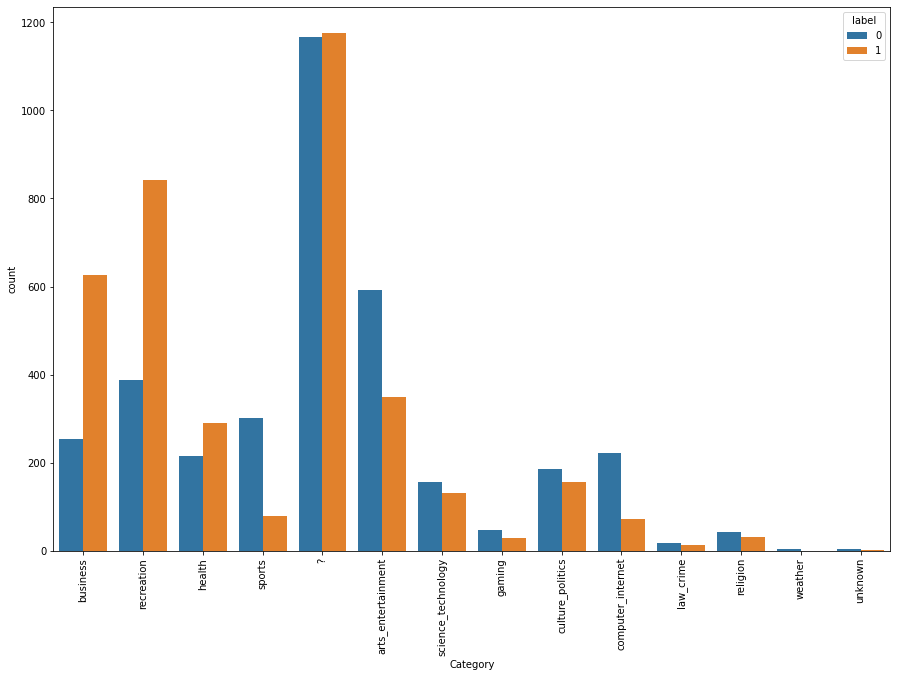

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(x=df['alchemy_category'],hue=df['label'])
plt.xlabel('Category')
plt.xticks(rotation=90)

Alchemy catergory does have a role in determining the label.

We see that business, recreation and health are more likley to be evergreen.

Where as sports, computer_internet and arts_entertainment are more like to be non-evergreen.

In [ ]:
df['is_news'].value_counts()

1    4552
?    2843
Name: is_news, dtype: int64

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

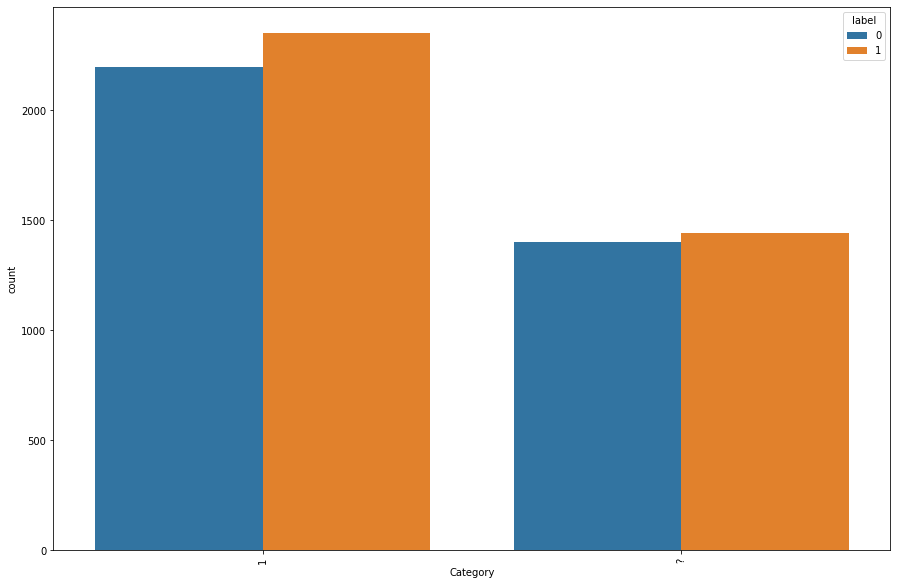

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(x=df['is_news'],hue=df['label'])
plt.xlabel('Category')
plt.xticks(rotation=90)

In [ ]:
df['news_front_page'].value_counts()

0    5853
?    1248
1     294
Name: news_front_page, dtype: int64

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

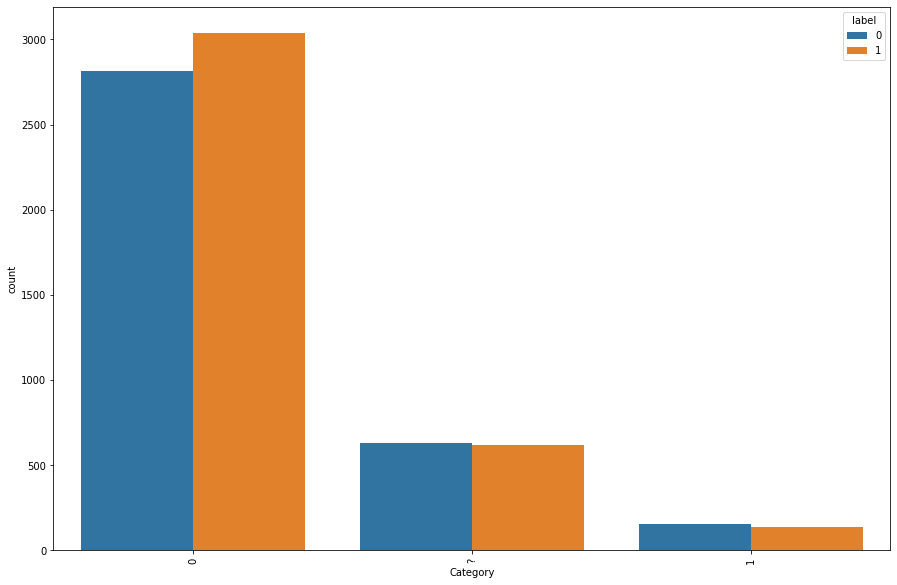

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(x=df['news_front_page'],hue=df['label'])
plt.xlabel('Category')
plt.xticks(rotation=90)

From the graphs, it is observed that both the 'is_news' and 'news_front_page' columns are redundant as they do not have any significant variance. So, these columns are dropped along with the 'alchemy_category_score' column. Further columns such as 'framebased', 'hasDomainLink', 'embed_ratio' are also dropped due the same reason mentioned above.

In [ ]:
df=df.drop(['alchemy_category_score','is_news','news_front_page','framebased','hasDomainLink','embed_ratio'], axis=1)
df.shape

(7395, 21)

In [ ]:
df_test=df_test.drop(['alchemy_category_score','is_news','news_front_page','framebased','hasDomainLink','embed_ratio'], axis=1)
df_test.shape

(3171, 20)

In [ ]:
test_df = df_test

Applying one_hot encoding to the 'alchemy_category' column

In [ ]:
df_alc= pd.get_dummies(df['alchemy_category'], drop_first = True)
df_alc.shape

(7395, 13)

In [ ]:
df_alc_test= pd.get_dummies(df_test['alchemy_category'], drop_first = True)
df_alc_test.shape

(3171, 11)

Applying one_hot encoding to the 'lengthyLinkDomain' column

In [ ]:
df_lengthy= pd.get_dummies(df['lengthyLinkDomain'], drop_first = True)
df_lengthy.shape

(7395, 1)

In [ ]:
df_lengthy_test= pd.get_dummies(df_test['lengthyLinkDomain'], drop_first = True)
df_lengthy_test.shape

(3171, 1)

In [ ]:
df_num = df.drop(['url','urlid','boilerplate','label'], axis=1)
df_num.shape

(7395, 17)

In [ ]:
df_num_test = df_test.drop(['url','urlid','boilerplate'], axis=1)
df_num_test.shape

(3171, 17)

Creating separate numerical dataframes for both train and test data from the original data

In [ ]:
df_numerical= pd.concat([df_alc,df_lengthy,df_num], axis=1)
df_numerical = df_numerical.drop(['alchemy_category','lengthyLinkDomain'],axis=1)
df_numerical.shape

(7395, 29)

In [ ]:
df_numerical.head()

,arts_entertainment,business,computer_internet,culture_politics,gaming,health,law_crime,recreation,religion,science_technology,sports,unknown,weather,1,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,frameTagRatio,html_ratio,image_ratio,linkwordscore,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio
0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.090774,0.245831,0.003883,24,5424,170,8,0.152941,0.079130
1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.098707,0.203490,0.088652,40,4973,187,9,0.181818,0.125448
2,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.072448,0.226402,0.120536,55,2240,258,11,0.166667,0.057613
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.095861,0.265656,0.035343,24,2737,120,5,0.041667,0.100858
4,0,0,0,0,0,0,0,0,0,0,1,0,0,1,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.024908,0.228887,0.050473,14,12032,162,10,0.098765,0.082569


Dropping columns which are not present in the test data

In [ ]:
df_numerical = df_numerical.drop(['unknown','weather'],axis=1)

In [ ]:
df_numerical_test= pd.concat([df_alc_test,df_lengthy_test,df_num_test], axis=1)
df_numerical_test = df_numerical_test.drop(['alchemy_category','lengthyLinkDomain'],axis=1)
df_numerical_test.shape

(3171, 27)

In [ ]:
df_numerical_test.head()

,arts_entertainment,business,computer_internet,culture_politics,gaming,health,law_crime,recreation,religion,science_technology,sports,1,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,frameTagRatio,html_ratio,image_ratio,linkwordscore,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio
0,0,0,0,0,0,0,0,1,0,0,0,1,2.558140,0.389706,0.257353,0.044118,0.022059,0.489572,0.067143,0.230285,0.199438,15,5643,136,3,0.242647,0.080597
1,0,0,0,1,0,0,0,0,0,0,0,1,3.771429,0.461538,0.205128,0.051282,0.000000,0.782051,0.042857,0.365962,0.080000,62,382,39,2,0.128205,0.176471
2,0,0,0,0,0,0,0,0,0,0,0,1,2.269565,0.495726,0.384615,0.170940,0.170940,1.250000,0.058824,0.161901,10.000000,42,2420,117,1,0.581197,0.125000
3,0,0,0,1,0,0,0,0,0,0,0,1,2.523490,0.705502,0.346278,0.122977,0.090615,0.449366,0.058081,0.146593,0.005964,41,5559,309,10,0.038835,0.063126
4,0,0,0,0,0,0,0,0,0,1,0,0,1.848000,0.470968,0.161290,0.032258,0.000000,0.453757,0.093023,0.244141,0.035714,34,2209,155,10,0.096774,0.065341


Applying scaling to the numerical data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler()

# transform training data
df_numerical = pd.DataFrame(norm.fit_transform(df_numerical))

In [ ]:
df_numerical.shape

(7395, 27)

In [ ]:
df_numerical_test = pd.DataFrame(norm.transform(df_numerical_test))

In [ ]:
df_numerical_test.shape

(3171, 27)

Applying Priciple Component Analysis for dimensionality reduction

Text(0.5, 1.0, 'Component-wise and Cumulative Explained Variance')

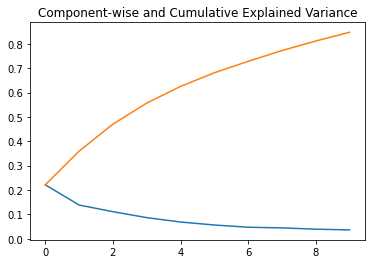

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca_result = pca.fit_transform(df_numerical.values)

plt.plot(range(10), pca.explained_variance_ratio_)
plt.plot(range(10), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")

From the graph, it is evident that considering n_components value as 6 is enough

Text(0.5, 1.0, 'Component-wise and Cumulative Explained Variance')

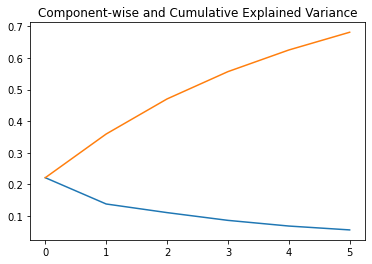

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
df_numerical = pd.DataFrame(pca.fit_transform(df_numerical.values))

plt.plot(range(6), pca.explained_variance_ratio_)
plt.plot(range(6), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")

In [ ]:
pca.explained_variance_ratio_

array([0.22133837, 0.13819098, 0.11092576, 0.08638501, 0.06844209,
       0.05616609])

In [ ]:
df_numerical_test = pd.DataFrame(pca.transform(df_numerical_test))

Creating separate text dataframes

In [ ]:
df_text = df[['boilerplate']]
df_text_test = df_test[['boilerplate']]

Removing the title and url word from each description

In [ ]:
df_text['boilerplate'].replace(to_replace=r'"title":', value="",inplace=True,regex=True)
df_text['boilerplate'].replace(to_replace=r'"url":',value="",inplace=True,regex=True)

df_text['boilerplate'].replace(to_replace=r'{|}',value="",inplace=True,regex=True)
df_text['boilerplate']=df_text['boilerplate'].str.lower()


#Cleaning the test dataframe 

df_text_test['boilerplate'].replace(to_replace=r'"title":', value="",inplace=True,regex=True)
df_text_test['boilerplate'].replace(to_replace=r'"url":',value="",inplace=True,regex=True)

df_text_test['boilerplate'].replace(to_replace=r'{|}',value="",inplace=True,regex=True)
df_text_test['boilerplate']=df_text_test['boilerplate'].str.lower()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

Concatnating both the numerical and text dataframes to do train test split

In [ ]:
df_train = pd.concat([df_numerical,df_text,df[['label']]], axis=1)

In [ ]:
df_test = pd.concat([df_numerical_test,df_text_test], axis=1)

In [ ]:
df_test.shape

(3171, 7)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop(['label'],axis=1), df_train['label'], test_size=0.25, random_state=324, stratify=df_train['label'])

In [ ]:
X_train

,0,1,2,3,4,5,boilerplate
4378,0.796815,-0.144212,0.049887,0.496646,0.731308,0.052826,""" "",""body"":"" "",""asiafood org"""
5705,-0.269177,0.850899,-0.092885,-0.194864,0.019977,0.007903,"""how to make a choco taco "",""body"":""choco taco..."
2358,0.548534,-0.088912,0.063211,0.129721,-0.114713,0.013266,"""cheese stuffed garlic breadsticks "",""body"":""w..."
2643,-0.402353,-0.043570,0.007055,0.123366,-0.028619,-0.056542,"""police muskegon man killed in crash discovere..."
6981,0.796880,-0.468358,-0.665751,-0.418702,-0.101498,-0.011572,"""quantum levitation hoverboards are now a "",""b..."
...,...,...,...,...,...,...,...
5459,-0.413932,-0.095026,0.037973,0.398991,-0.503190,0.678104,"""17 ways to improve your sleep "",""body"":""welco..."
1100,-0.453475,-0.061774,0.016910,0.241796,-0.027829,-0.162298,"""google to buy its own web domain google to bu..."
2196,-0.360590,-0.398889,-0.720778,-0.362238,0.099833,0.075447,"""butterscotch blondie bars with peanut pretzel..."
6062,-0.313654,-0.082053,0.017137,0.177852,-0.148091,-0.284779,"""sodexo s meatless mondays give where s the be..."


In [ ]:
from transformers import AutoTokenizer, TFAutoModel


#Downloading the tokenizer and the Albert model for fine tuning

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert=TFAutoModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
SEQ_length=512

Tokenizing the text data

In [ ]:
train_tokens = tokenizer.batch_encode_plus(X_train['boilerplate'].to_list(),max_length=SEQ_length,padding=True,
                           truncation=True,return_token_type_ids=False)

val_tokens = tokenizer.batch_encode_plus(X_val['boilerplate'].to_list(),max_length=SEQ_length,padding=True,
                           truncation=True,return_token_type_ids=False)

test_tokens = tokenizer.batch_encode_plus(df_test['boilerplate'].to_list(),max_length=SEQ_length,padding=True,
                           truncation=True,return_token_type_ids=False)

In [ ]:
# for train set
train_seq = torch.tensor(train_tokens['input_ids'])
train_mask = torch.tensor(train_tokens['attention_mask'])
train_y = torch.tensor(y_train.tolist())

# for validation set
val_seq = torch.tensor(val_tokens['input_ids'])
val_mask = torch.tensor(val_tokens['attention_mask'])
val_y = torch.tensor(y_val.tolist())

# for test set
test_seq = torch.tensor(test_tokens['input_ids'])
test_mask = torch.tensor(test_tokens['attention_mask'])

Considering the numerical data as a meta data while creating dataset

Train Data

In [ ]:
import tensorflow as tf
train_data=tf.data.Dataset.from_tensor_slices((train_seq,train_mask,X_train.drop('boilerplate',axis=1),train_y))

def map_func(input_ids,mask,meta_input,labels):
    return {'input_ids':input_ids,'attention_mask':mask,'meta_input': meta_input},labels

train_data = train_data.map(map_func)
train_data = train_data.shuffle(100000).batch(32).prefetch(1000)

DS_size=len(list(train_data))

Validation data

In [ ]:
val_data=tf.data.Dataset.from_tensor_slices((val_seq,val_mask,X_val.drop('boilerplate',axis=1), val_y))

def map_func(input_ids,mask,meta_input,labels):
    return {'input_ids':input_ids,'attention_mask':mask,'meta_input': meta_input},labels

val_data = val_data.map(map_func)
val_data = val_data.shuffle(100000).batch(32).prefetch(1000)

Test Data

In [ ]:
test_data=tf.data.Dataset.from_tensor_slices((test_seq,test_mask, df_test.drop('boilerplate',axis=1)))

def map_func(input_ids,mask, meta_input):
    return {'input_ids':input_ids,'attention_mask':mask,'meta_input': meta_input}

test_data = test_data.map(map_func)
test_data = test_data.shuffle(100000).batch(32).prefetch(1000)


**Building model**

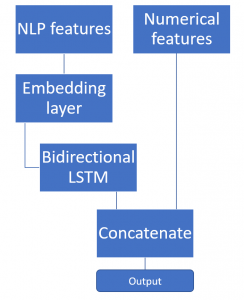

Concatnating the numerical data and the embedded text data by following the above mentioned picture

In [ ]:
input_ids=tf.keras.layers.Input(shape=(SEQ_length,),name='input_ids',dtype='int32')
input_mask=tf.keras.layers.Input(shape=(SEQ_length,),name='attention_mask',dtype='int32')

meta_input = tf.keras.layers.Input(shape=(6,),name='meta_input')

embedding=bert(input_ids,attention_mask=input_mask)[0]
#x=tf.keras.layers.GlobalMaxPool1D()(embedding)
x=tf.keras.layers.GlobalAveragePooling1D()(embedding)
nlp_out=tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.concatenate([nlp_out, meta_input])
x=tf.keras.layers.Dense(128,activation='relu')(x)
x=tf.keras.layers.Dropout(0.3)(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
output=tf.keras.layers.Dense(1,activation='sigmoid')(x)


model=tf.keras.Model(inputs=[input_ids,input_mask,meta_input],outputs=output)

model.layers[2].trainable=False


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 768)          0           tf_bert_model[0][0]          

Compiling the model

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam',metrics=['accuracy',tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

Training the model with 20 epochs

In [ ]:
history=model.fit(train_data,validation_data=val_data,epochs=20)

Epoch 1/20
174/174 [==============================] - 371s 2s/step - loss: 0.5603 - accuracy: 0.7410 - auc: 0.7967 - precision: 0.7653 - recall: 0.7173 - val_loss: 0.5255 - val_accuracy: 0.7647 - val_auc: 0.8693 - val_precision: 0.7231 - val_recall: 0.8778
Epoch 2/20
174/174 [==============================] - 364s 2s/step - loss: 0.4483 - accuracy: 0.8018 - auc: 0.8721 - precision: 0.8255 - recall: 0.7851 - val_loss: 0.4647 - val_accuracy: 0.8188 - val_auc: 0.8782 - val_precision: 0.8287 - val_recall: 0.8156
Epoch 3/20
174/174 [==============================] - 363s 2s/step - loss: 0.4335 - accuracy: 0.8117 - auc: 0.8804 - precision: 0.8399 - recall: 0.7759 - val_loss: 0.4328 - val_accuracy: 0.8172 - val_auc: 0.8856 - val_precision: 0.8166 - val_recall: 0.8303
Epoch 4/20
174/174 [==============================] - 363s 2s/step - loss: 0.4251 - accuracy: 0.8056 - auc: 0.8854 - precision: 0.8286 - recall: 0.7878 - val_loss: 0.4347 - val_accuracy: 0.8118 - val_auc: 0.8802 - val_precision: 

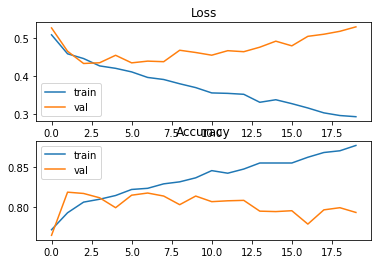

In [ ]:
from matplotlib import pyplot

# plot loss during training
pyplot.subplot(2,1,1)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(2,1,2)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.show()

Predicting the test labels

In [ ]:
predictions=model.predict(test_data)
predictions = pd.DataFrame(predictions.round())

In [ ]:
predictions.value_counts()

1.0    1656
0.0    1515
dtype: int64

Saving the test label as a csv file

In [ ]:
test_df['label']=predictions

test_df.to_csv('/content/drive/MyDrive/Stumble Upon/submit.csv',columns=['urlid','label'],index=False)

Saving the model for future use

In [ ]:
from tensorflow import keras

model.save("/content/drive/MyDrive/Stumble Upon/Stumble_upon_classification_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Stumble Upon/Stumble_upon_classification_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Stumble Upon/Stumble_upon_classification_model/assets


**References**
  
  https://www.kaggle.com/sumeetsawant/stumble-upon-challenge-auc-private-lb-0-85

  http://cs229.stanford.edu/proj2013/RoySaraiya_StumbleUponClassification.pdf

  https://github.com/huggingface/transformers
  
  https://medium.com/@aniruddha.choudhury94/part-2-bert-fine-tuning-tutorial-with-pytorch-for-text-classification-on-the-corpus-of-linguistic-18057ce330e1

  http://digital-thinking.de/deep-learning-combining-numerical-and-text-features-in-deep-neural-networks/

  https://github.com/prateekjoshi565/Fine-Tuning-BERT/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb